In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, make_scorer


In [4]:
### Function to reorder columns
### In order to keep the feature column as the last

# Function to reorder columns
def reorder_columns(df):
    cols = list(df.columns)
    # Remove 'feature' column and add it to the end
    cols.remove('feature')
    cols.append('feature')
    return df[cols]

def plot_forward_translocation_quantiles(data, feature_column, quantiles, feature_columns):
    """
    Plots the specified quantiles of forward translocation times for non-B and B-DNA structures.

    Parameters:
    - data: DataFrame containing the combined data.
    - feature_column: Column name used to identify non-B and B-DNA structures.
    - quantiles: List of quantiles to plot (e.g., [0.5, 0.75, 0.95]).
    - feature_columns: List of feature column names (e.g., ['forward_tt_1', 'forward_tt_2', ...]).

    Returns:
    - None: Displays a plot.
    """
    # Calculate quantiles for forward translocation times
    nonb_forward_quantiles = data[data[feature_column] == 1][feature_columns].quantile(quantiles)
    bdna_forward_quantiles = data[data[feature_column] == 0][feature_columns].quantile(quantiles)

    # Plot forward translocation times quantiles
    plt.figure(figsize=(10, 6))
    base_positions = nonb_forward_quantiles.columns.str.extract(r'(\d+)')[0].astype(int)

    # Define colors for each quantile
    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Add more colors if needed

    for idx, q in enumerate(quantiles):
        nonb_line = nonb_forward_quantiles.loc[q]
        bdna_line = bdna_forward_quantiles.loc[q]

        # Plot lines for non-B DNA and B-DNA structures with matching colors for each quantile
        plt.plot(base_positions, nonb_line, label=f'Non-B DNA Forward {int(q*100)}th percentile', linestyle='-', color=colors[idx])
        plt.plot(base_positions, bdna_line, label=f'B-DNA Forward {int(q*100)}th percentile', linestyle='--', color=colors[idx])

    plt.xlabel('Base Position')
    plt.ylabel('Translocation Time')
    plt.title('Forward Translocation Time per Base Position (Quantiles)')
    plt.legend()
    plt.grid(True)
    plt.show()


Non-B DNA data shape: (32631, 102)
Selecting this many rows of B-DNA: 40000
B-DNA data shape: (40000, 102)
Combined dataframe (B-DNA + Non-B DNA) shape: (72631, 102)
Feature matrix (X) shape: (72631, 101)
Label vector (y) shape: (72631,)


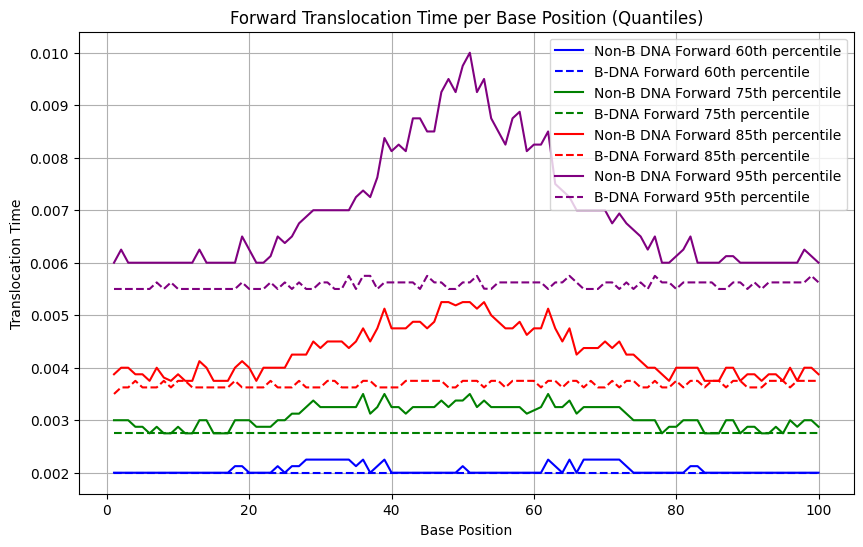

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Data Preparation
# Define the non-B DNA structure type
nonb = "G_Quadruplex_Motif"
#nonb = "Short_Tandem_Repeat"
#nonb = "Z_DNA_Motif"
#nonb = "A_Phased_Repeat"

# Paths to your train, test, and validation datasets for non-b DNA structure
base_path = '/home/alextu/scratch/model_test_data_hg00268/prepared_datasets_nonb_dna_oneway_15-22-Y'
train_nonb_file = f'{base_path}/{nonb}_train.csv'
test_nonb_file = f'{base_path}/{nonb}_test.csv'
val_nonb_file = f'{base_path}/{nonb}_validation.csv'

# Read train, test, and validation datasets for non-B structures
train_nonb_data = pd.read_csv(train_nonb_file)
test_nonb_data = pd.read_csv(test_nonb_file)
val_nonb_data = pd.read_csv(val_nonb_file)

# Reorder columns for each DataFrame
train_nonb_data = reorder_columns(train_nonb_data)
test_nonb_data = reorder_columns(test_nonb_data)
val_nonb_data = reorder_columns(val_nonb_data)

# Concatenate train, test, and validation datasets vertically
combined_nonb_data = pd.concat([train_nonb_data, test_nonb_data, val_nonb_data], ignore_index=True)

# Map categorical labels to numeric values: 1 for non-B DNA
combined_nonb_data['feature'] = 1
print("Non-B DNA data shape:", combined_nonb_data.shape)

# Paths to your train, test, and validation datasets for B-DNA structure
bdna_base_path = '/home/alextu/scratch/model_test_data_hg00268/prepared_datasets_bdna_oneway_15-22-Y'
train_bdna_file = f'{bdna_base_path}/bdna_train.csv'
test_bdna_file = f'{bdna_base_path}/bdna_test.csv'
val_bdna_file = f'{bdna_base_path}/bdna_validation.csv'

# Read train, test, and validation datasets for B-DNA structures
train_bdna_data = pd.read_csv(train_bdna_file)
test_bdna_data = pd.read_csv(test_bdna_file)
val_bdna_data = pd.read_csv(val_bdna_file)

# Reorder columns for each DataFrame
train_bdna_data = reorder_columns(train_bdna_data)
test_bdna_data = reorder_columns(test_bdna_data)
val_bdna_data = reorder_columns(val_bdna_data)

# Concatenate train, test, and validation datasets vertically
combined_bdna_data = pd.concat([train_bdna_data, test_bdna_data, val_bdna_data], ignore_index=True)

# Sample the same number of rows as in the combined_nonb_data
#n = len(combined_nonb_data)
n = 40000
print("Selecting this many rows of B-DNA:", n)
combined_bdna_data = combined_bdna_data.sample(n=n, random_state=42)  # Use a fixed random state for reproducibility

# Map categorical labels to numeric values: 0 for B-DNA
combined_bdna_data['feature'] = 0
print("B-DNA data shape:", combined_bdna_data.shape)

# Concatenate B-DNA and non-B DNA data
combined_data = pd.concat([combined_nonb_data, combined_bdna_data], ignore_index=True)
# Extract feature columns (forward translocation times) and label column
forward_tt_columns = [f'forward_tt_{i}' for i in range(1, 101)]

# Define the additional column name - FOR ADDING ADDITIONAL FEATURES
extra_column = 'coverage'

# Combine the forward_tt columns and the additional column
feature_columns = forward_tt_columns + [extra_column]

X = combined_data[feature_columns].values  # Features (forward translocation times)
y = combined_data.iloc[:, -1].values       # Labels (last column, -1)

# Print combined dataframe shape
print("Combined dataframe (B-DNA + Non-B DNA) shape:", combined_data.shape)
print("Feature matrix (X) shape:", X.shape)
print("Label vector (y) shape:", y.shape)

# Example usage:
quantiles = [0.6, 0.75, 0.85, 0.95]
feature_columns = [f'forward_tt_{i}' for i in range(1, 101)]  # Adjust based on your column naming pattern
feature_column = 'feature'  # The column that indicates non-B (1) and B-DNA (0)

# Assuming combined_data is your DataFrame that you have already prepared
plot_forward_translocation_quantiles(combined_data, feature_column, quantiles, feature_columns)

In [7]:
# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled)

# Convert to PyTorch tensors
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshape y to [n_samples, 1]

print(X_scaled_tensor.shape)
print(y_tensor.shape)

[[-0.14285714  0.57142857  5.         ... -0.28571429  1.14285714
   2.        ]
 [ 2.          0.5         0.21428571 ... -0.28571429  1.35714286
   2.2       ]
 [ 0.57142857  0.42857143  0.57142857 ...  1.21428571  0.35714286
   2.2       ]
 ...
 [ 0.42857143 -0.14285714  0.         ... -0.28571429 -0.28571429
  -1.2       ]
 [ 0.35714286 -0.07142857 -0.28571429 ... -0.14285714  0.14285714
   1.        ]
 [ 1.28571429  0.14285714  1.71428571 ... -0.28571429  3.71428571
   0.4       ]]
torch.Size([72631, 101])
torch.Size([72631, 1])


In [8]:
# Split Data into train and test sets with shuffling
#X_train, X_test, y_train, y_test = train_test_split(X_scaled_tensor, y_tensor, test_size=0.33, random_state=42, shuffle=True)

# Further split the training data into training and validation sets with shuffling
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True)

# Split Data into 75% training and 25% testing sets with shuffling
X_train, X_test, y_train, y_test = train_test_split(X_scaled_tensor, y_tensor, test_size=0.25, random_state=42, shuffle=True)

# Further split the training data into training and validation sets with shuffling
# Here we'll use 75% of the 75% for training and 25% of the 75% for validation, which gives a 56.25% training and 18.75% validation split overall.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)


# Print shapes and counts of samples
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

# Print total samples in each set
print("Total Samples in training set:", X_train.shape[0])
print("Total Samples in validation set:", X_val.shape[0])
print("Total Samples in testing set:", X_test.shape[0])

# Count occurrences of each value (0 and 1) in training, validation, and testing sets
count_nonb_train = torch.sum(y_train == 1).item()  # Count of 1s
count_nonb_val = torch.sum(y_val == 1).item()  # Count of 1s
count_nonb_test = torch.sum(y_test == 1).item()  # Count of 1s

count_bdna_train = torch.sum(y_train == 0).item()  # Count of 0s
count_bdna_val = torch.sum(y_val == 0).item()  # Count of 0s
count_bdna_test = torch.sum(y_test == 0).item()  # Count of 0s

print("Number of non-b structures in training set:", count_nonb_train)
print("Number of non-b structures in validation set:", count_nonb_val)
print("Number of non-b structures in test set:", count_nonb_test)

print("Number of b-dna structures in training set:", count_bdna_train)
print("Number of b-dna structures in validation set:", count_bdna_val)
print("Number of b-dna structures in test set:", count_bdna_test)

X_train shape: torch.Size([40854, 101])
X_val shape: torch.Size([13619, 101])
X_test shape: torch.Size([18158, 101])
y_train shape: torch.Size([40854, 1])
y_val shape: torch.Size([13619, 1])
y_test shape: torch.Size([18158, 1])
Total Samples in training set: 40854
Total Samples in validation set: 13619
Total Samples in testing set: 18158
Number of non-b structures in training set: 18305
Number of non-b structures in validation set: 6215
Number of non-b structures in test set: 8111
Number of b-dna structures in training set: 22549
Number of b-dna structures in validation set: 7404
Number of b-dna structures in test set: 10047


In [9]:
import csv
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(101, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, params):
    """
    Train the model using specified parameters.
    This function handles the training process.

    Args:
        model (torch.nn.Module): The neural network model.
        criterion: The loss function.
        optimizer: The optimizer.
        X_train (torch.Tensor): The input training data.
        y_train (torch.Tensor): The target training labels.
        X_val (torch.Tensor): The input validation data.
        y_val (torch.Tensor): The target validation labels.
        params (dict): Dictionary containing training parameters.

    Returns:
        list: List of training losses for each epoch.
        list: List of validation losses for each epoch.
    """
    model.train()
    train_losses = []
    val_losses = []
    epochs = params.get('epochs', 300)
    batch_size = params.get('batch_size', 32)
    learning_rate = params.get('learning_rate', 0.001)

    for epoch in range(epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0
        
        # Training phase
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i + batch_size]
            labels = y_train[i:i + batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / (len(X_train) / batch_size)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                val_inputs = X_val[i:i + batch_size]
                val_labels = y_val[i:i + batch_size]

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                running_val_loss += val_loss.item()

            epoch_val_loss = running_val_loss / (len(X_val) / batch_size)
            val_losses.append(epoch_val_loss)

        model.train()
        
        print(f"Epoch {epoch + 1}, Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}")

    return train_losses, val_losses

def plot_loss_curve(train_losses, val_losses, ax):
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Curve')
    ax.legend()

def evaluate_model(model, criterion, X_test, y_test):
    """
    Evaluate the model on the test set.

    Args:
        model (torch.nn.Module): The trained neural network model.
        criterion: The loss function.
        X_test (torch.Tensor): The input test data.
        y_test (torch.Tensor): The target test labels.

    Returns:
        float: Test loss.
        float: Test accuracy.
        float: Precision.
        float: Recall.
        float: F1 score.
        ndarray: False positive rate.
        ndarray: True positive rate.
        float: AUC score.
        torch.Tensor: Predicted labels.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted_labels = (outputs >= 0.5).float()

        accuracy = (predicted_labels == y_test).float().mean()

        loss = criterion(outputs, y_test)

        precision = precision_score(y_test, predicted_labels)
        recall = recall_score(y_test, predicted_labels)
        f1 = f1_score(y_test, predicted_labels)

        fpr, tpr, _ = roc_curve(y_test, outputs)
        auc_score = roc_auc_score(y_test, outputs)

    return loss.item(), accuracy.item(), precision, recall, f1, fpr, tpr, auc_score, predicted_labels

def plot_confusion_matrix(y_true, y_pred, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

def plot_roc_curve(fpr, tpr, auc_score, ax):
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")


In [11]:
import csv
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold


if __name__ == "__main__":
    # List of learning rates, epochs, and batch sizes to iterate over
    learning_rates = [1e-5]
    epochs_list = [200]
    batch_sizes = [32]
    #weight_decay = 1e-2

    # Ensure the output directory exists
    output_dir = "/home/alextu/scratch/model_test_data_hg00268/training_results/{nonb}"
    os.makedirs(output_dir, exist_ok=True)

    # CSV file to save evaluation metrics
    csv_file = os.path.join(output_dir, "evaluation_metrics.csv")

    # Write the header for the CSV file
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Parameters", "Learning Rate", "Epochs", "Batch Size", "Test Loss", "Test Accuracy", "Precision", "Recall", "F1 Score"])

    for lr in learning_rates:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                # Create model instance
                model = NeuralNetwork()

                # Define loss function and optimizer
                criterion = nn.BCELoss()
                
                # Define training parameters
                training_params = {
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'learning_rate': lr
                }

                # Create optimizer with learning rate and weight decay
                #optimizer = optim.Adam(model.parameters(), lr=training_params['learning_rate'], weight_decay=weight_decay)
                # without weight decay
                optimizer = optim.Adam(model.parameters(), lr=training_params['learning_rate'])


                # Train the model
                train_losses, val_losses = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, params=training_params)

                # Evaluate the model on the test set
                test_loss, test_accuracy, precision, recall, f1, fpr, tpr, auc_score, predicted_labels = evaluate_model(model, criterion, X_test, y_test)

                # Create subplots for other plots
                fig, axes = plt.subplots(1, 3, figsize=(24, 8))

                # Plot the training loss curve
                plot_loss_curve(train_losses, val_losses, axes[0])

                # Plot confusion matrix
                plot_confusion_matrix(y_test, predicted_labels, axes[1])

                # Plot ROC curve
                plot_roc_curve(fpr, tpr, auc_score, axes[2])

                # Add text annotations with training parameters
                text_str = (f"Training Parameters:\n"
                            f"Learning Rate: {training_params['learning_rate']}\n"
                            f"Batch Size: {training_params['batch_size']}\n"
                            f"Epochs: {training_params['epochs']}")
                
                # Add the text annotation inside the figure, on the right side but within bounds
                fig.text(0.92, 0.5, text_str, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

                # Loop over subplots to set the color of axes labels and ticks to white
                for ax in axes:
                    ax.tick_params(axis='x', colors='white')
                    ax.tick_params(axis='y', colors='white')
                    ax.xaxis.label.set_color('white')
                    ax.yaxis.label.set_color('white')
            
                # Display the other plots
                plt.tight_layout()

                # Save the figure for other plots
                plt.savefig(os.path.join(output_dir, f"results_lr_{lr}_epochs_{epochs}_batch_{batch_size}_noweight.png"))
                plt.close()

                # Save evaluation metrics to the CSV file
                with open(csv_file, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow([f"LR={lr}, Epochs={epochs}, Batch={batch_size}", lr, epochs, batch_size, test_loss, test_accuracy, precision, recall, f1])

                # Print evaluation metrics
                print(f"Learning Rate: {lr}, Epochs: {epochs}, Batch Size: {batch_size}")

Epoch 1, Train Loss: 0.6985634615483506, Val Loss: 0.6959024293892394
Epoch 2, Train Loss: 0.6803957968140545, Val Loss: 0.6810288320370941
Epoch 3, Train Loss: 0.6663828219658724, Val Loss: 0.6608898694473738
Epoch 4, Train Loss: 0.652319883071198, Val Loss: 0.6457093728517364
Epoch 5, Train Loss: 0.6377306639514971, Val Loss: 0.6310408743688806
Epoch 6, Train Loss: 0.6225791114971093, Val Loss: 0.6158435956541947
Epoch 7, Train Loss: 0.6070671969061878, Val Loss: 0.6004431789181676
Epoch 8, Train Loss: 0.5915916521491916, Val Loss: 0.585230723063898
Epoch 9, Train Loss: 0.5764231688359903, Val Loss: 0.5705037407959441
Epoch 10, Train Loss: 0.5618935955856412, Val Loss: 0.556601956759144
Epoch 11, Train Loss: 0.5482461429023939, Val Loss: 0.543700722032588
Epoch 12, Train Loss: 0.5357089412424214, Val Loss: 0.531927992973885
Epoch 13, Train Loss: 0.5242460335778053, Val Loss: 0.5211674564691251
Epoch 14, Train Loss: 0.513859042373413, Val Loss: 0.5114598264077291
Epoch 15, Train Loss:

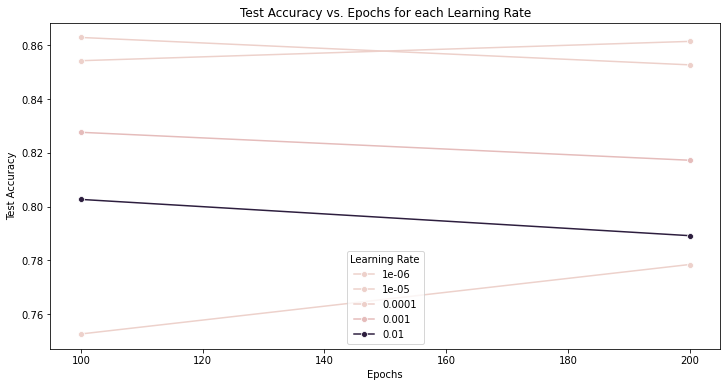

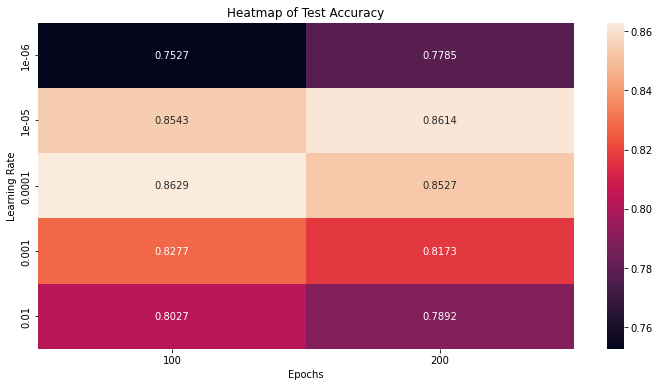

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
file_path = '/Users/alexanderturco/Desktop/model_test_data_hg00268/training_results/{nonb}/evaluation_metrics.csv'
df = pd.read_csv(file_path)

# Create Line Plots
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epochs', y='Test Accuracy', hue='Learning Rate', marker='o')
plt.title('Test Accuracy vs. Epochs for each Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend(title='Learning Rate')
plt.show()

# Create Heatmaps
pivot_table = df.pivot("Learning Rate", "Epochs", "Test Accuracy")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f")
plt.title('Heatmap of Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()


Epoch 1, Train Loss: 0.6900272774980121, Val Loss: 0.6826289462541341
Epoch 2, Train Loss: 0.6804708444010404, Val Loss: 0.6728693227145855
Epoch 3, Train Loss: 0.671106951387656, Val Loss: 0.6629841292944667
Epoch 4, Train Loss: 0.6613871676501003, Val Loss: 0.6526782888193753
Epoch 5, Train Loss: 0.6510844375819977, Val Loss: 0.6419538272198929
Epoch 6, Train Loss: 0.6400997669705635, Val Loss: 0.6305986770202241
Epoch 7, Train Loss: 0.6284773044908907, Val Loss: 0.6186105020626014
Epoch 8, Train Loss: 0.6163053365800246, Val Loss: 0.6061359415321598
Epoch 9, Train Loss: 0.6037506509928007, Val Loss: 0.5933662886544288
Epoch 10, Train Loss: 0.5910317872921088, Val Loss: 0.58056725639854
Epoch 11, Train Loss: 0.5784070459912144, Val Loss: 0.5680045466457465
Epoch 12, Train Loss: 0.566120383329718, Val Loss: 0.5558734126284166
Epoch 13, Train Loss: 0.5543596557861362, Val Loss: 0.5443857710271902
Epoch 14, Train Loss: 0.5433043478839791, Val Loss: 0.5336679428972677
Epoch 15, Train Los

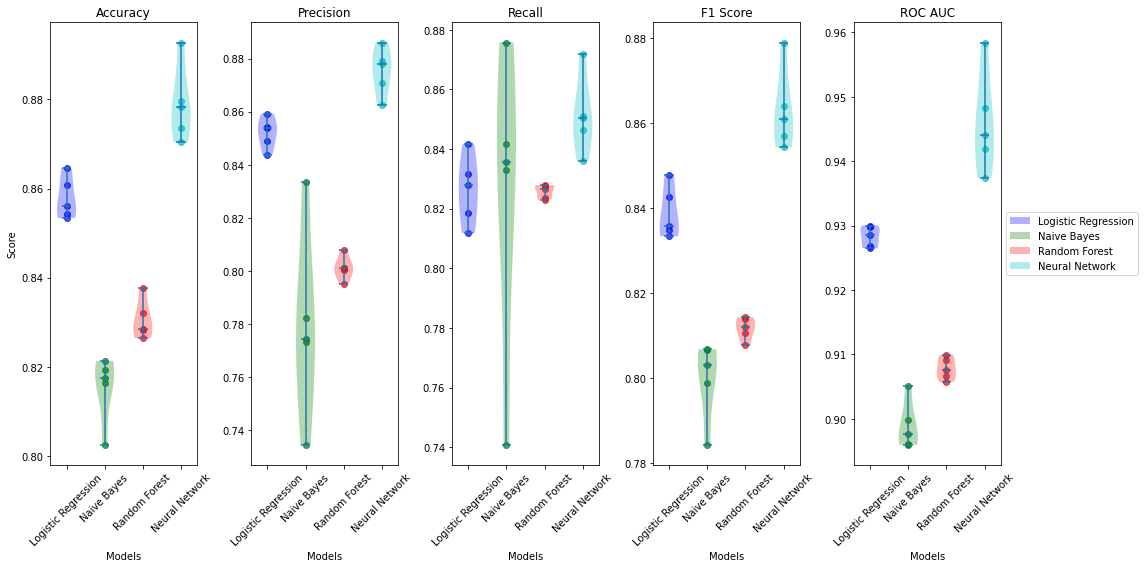

In [26]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Import SVM classifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define a function for cross-validation
def cross_validate(model, X, y, criterion, optimizer, params, n_splits=5):
    """
    Perform cross-validation on the model.

    Args:
        model (torch.nn.Module): The neural network model.
        X (torch.Tensor): The input data.
        y (torch.Tensor): The target labels.
        criterion: The loss function.
        optimizer: The optimizer.
        params (dict): Dictionary containing training parameters.
        n_splits (int): Number of splits for cross-validation.

    Returns:
        list: List of dictionaries containing evaluation metrics for each fold.
    """
    kf = KFold(n_splits=n_splits, shuffle=True)
    fold_metrics = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_losses, val_losses = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, params)

        test_loss, test_accuracy, precision, recall, f1, fpr, tpr, auc_score, predicted_labels = evaluate_model(model, criterion, X_val, y_val)

        fold_metrics.append({
            'Fold': fold + 1,
            'Test Loss': test_loss,
            'Test Accuracy': test_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC Score': auc_score
        })

    return fold_metrics

# Assuming you have your X_train, y_train, X_val, and y_val datasets and your train_model and evaluate_model functions defined

# Define your training parameters
learning_rate = 1e-5
batch_size = 32
epochs = 150

# Create model instance
model = NeuralNetwork()

# Define your criterion and optimizer
criterion = nn.BCELoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)

# without weight decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call the cross_validate function
fold_metrics = cross_validate(model, X_train, y_train, criterion, optimizer, params={'learning_rate': learning_rate, 'batch_size': batch_size, 'epochs': epochs})

# Collect evaluation metrics
nn_test_accuracies = [fold['Test Accuracy'] for fold in fold_metrics]
nn_precisions = [fold['Precision'] for fold in fold_metrics]
nn_recalls = [fold['Recall'] for fold in fold_metrics]
nn_f1_scores = [fold['F1 Score'] for fold in fold_metrics]
nn_auc_scores = [fold['AUC Score'] for fold in fold_metrics]

# Reshape y_train
y_train2 = y_train.ravel()

# Define classifiers
print("Defining classifiers...")
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Initialize dictionaries to store performance metrics
metrics = {metric: [] for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']}
nn_metrics = {'Accuracy': nn_test_accuracies, 'Precision': nn_precisions, 'Recall': nn_recalls, 'F1 Score': nn_f1_scores, 'ROC AUC': nn_auc_scores}

# Loop through classifiers
print("Looping through classifiers and training models...")
for name, clf in classifiers.items():
    print(f"Evaluating {name}...")
    # Perform cross-validation
    scores_accuracy = cross_val_score(clf, X_train, y_train2, cv=5, scoring='accuracy')
    scores_precision = cross_val_score(clf, X_train, y_train2, cv=5, scoring='precision')
    scores_recall = cross_val_score(clf, X_train, y_train2, cv=5, scoring='recall')
    scores_f1 = cross_val_score(clf, X_train, y_train2, cv=5, scoring='f1')
    if hasattr(clf, "predict_proba"):
        scores_roc_auc = cross_val_score(clf, X_train, y_train2, cv=5, scoring='roc_auc')
    else:
        scores_roc_auc = [np.nan] * 5

    # Store metrics
    metrics['Accuracy'].append(scores_accuracy)
    metrics['Precision'].append(scores_precision)
    metrics['Recall'].append(scores_recall)
    metrics['F1 Score'].append(scores_f1)
    metrics['ROC AUC'].append(scores_roc_auc)

# Create the plot
plt.figure(figsize=(16, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Added more colors to cover all models

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

for i, metric_name in enumerate(metric_names):
    positions = np.arange(1, len(classifiers) + 2)
    plt.subplot(1, len(metric_names), i+1)
    
    data_to_plot = [metrics[metric_name][j] for j in range(len(classifiers))] + [nn_metrics[metric_name]]
    
    parts = plt.violinplot(data_to_plot, positions=positions, showmedians=True)
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
    
    for pos in positions:
        plt.scatter([pos]*len(data_to_plot[pos-1]), data_to_plot[pos-1], color=colors[pos-1], alpha=0.7)
    
    plt.title(metric_name)
    plt.xlabel('Models')
    plt.xticks(positions, list(classifiers.keys()) + ['Neural Network'], rotation=45)
    if i == 0:
        plt.ylabel('Score')

# Move the legend to the right of the plot
plt.legend(list(classifiers.keys()) + ['Neural Network'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()